In [36]:

# General
import numpy as np

# Qiskit imports
from qiskit import QuantumCircuit,  ClassicalRegister, QuantumRegister
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import SamplerV2 as Sampler

# Qiskit Runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# Plotting routines
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram

#title


In [39]:
## Save your IBM Quantum account and set it as your default account.
QiskitRuntimeService.save_account(

    channel="ibm_quantum",

    token="0c58722dfa2bdbbdb16fcd4bd700c0a06c70f31889734b04456cb6b1371576bc8540bc7796fa9f263386274194b24ed63ae4c0a1e749048fd9fdbcef2d4d4eef",

    set_as_default=True,

    # Use `overwrite=True` if you're updating your token.
    overwrite=True,
)


In [40]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
backend.name

'ibm_brisbane'

# Shor 9 qubit code 


# applyed error correctig gates 

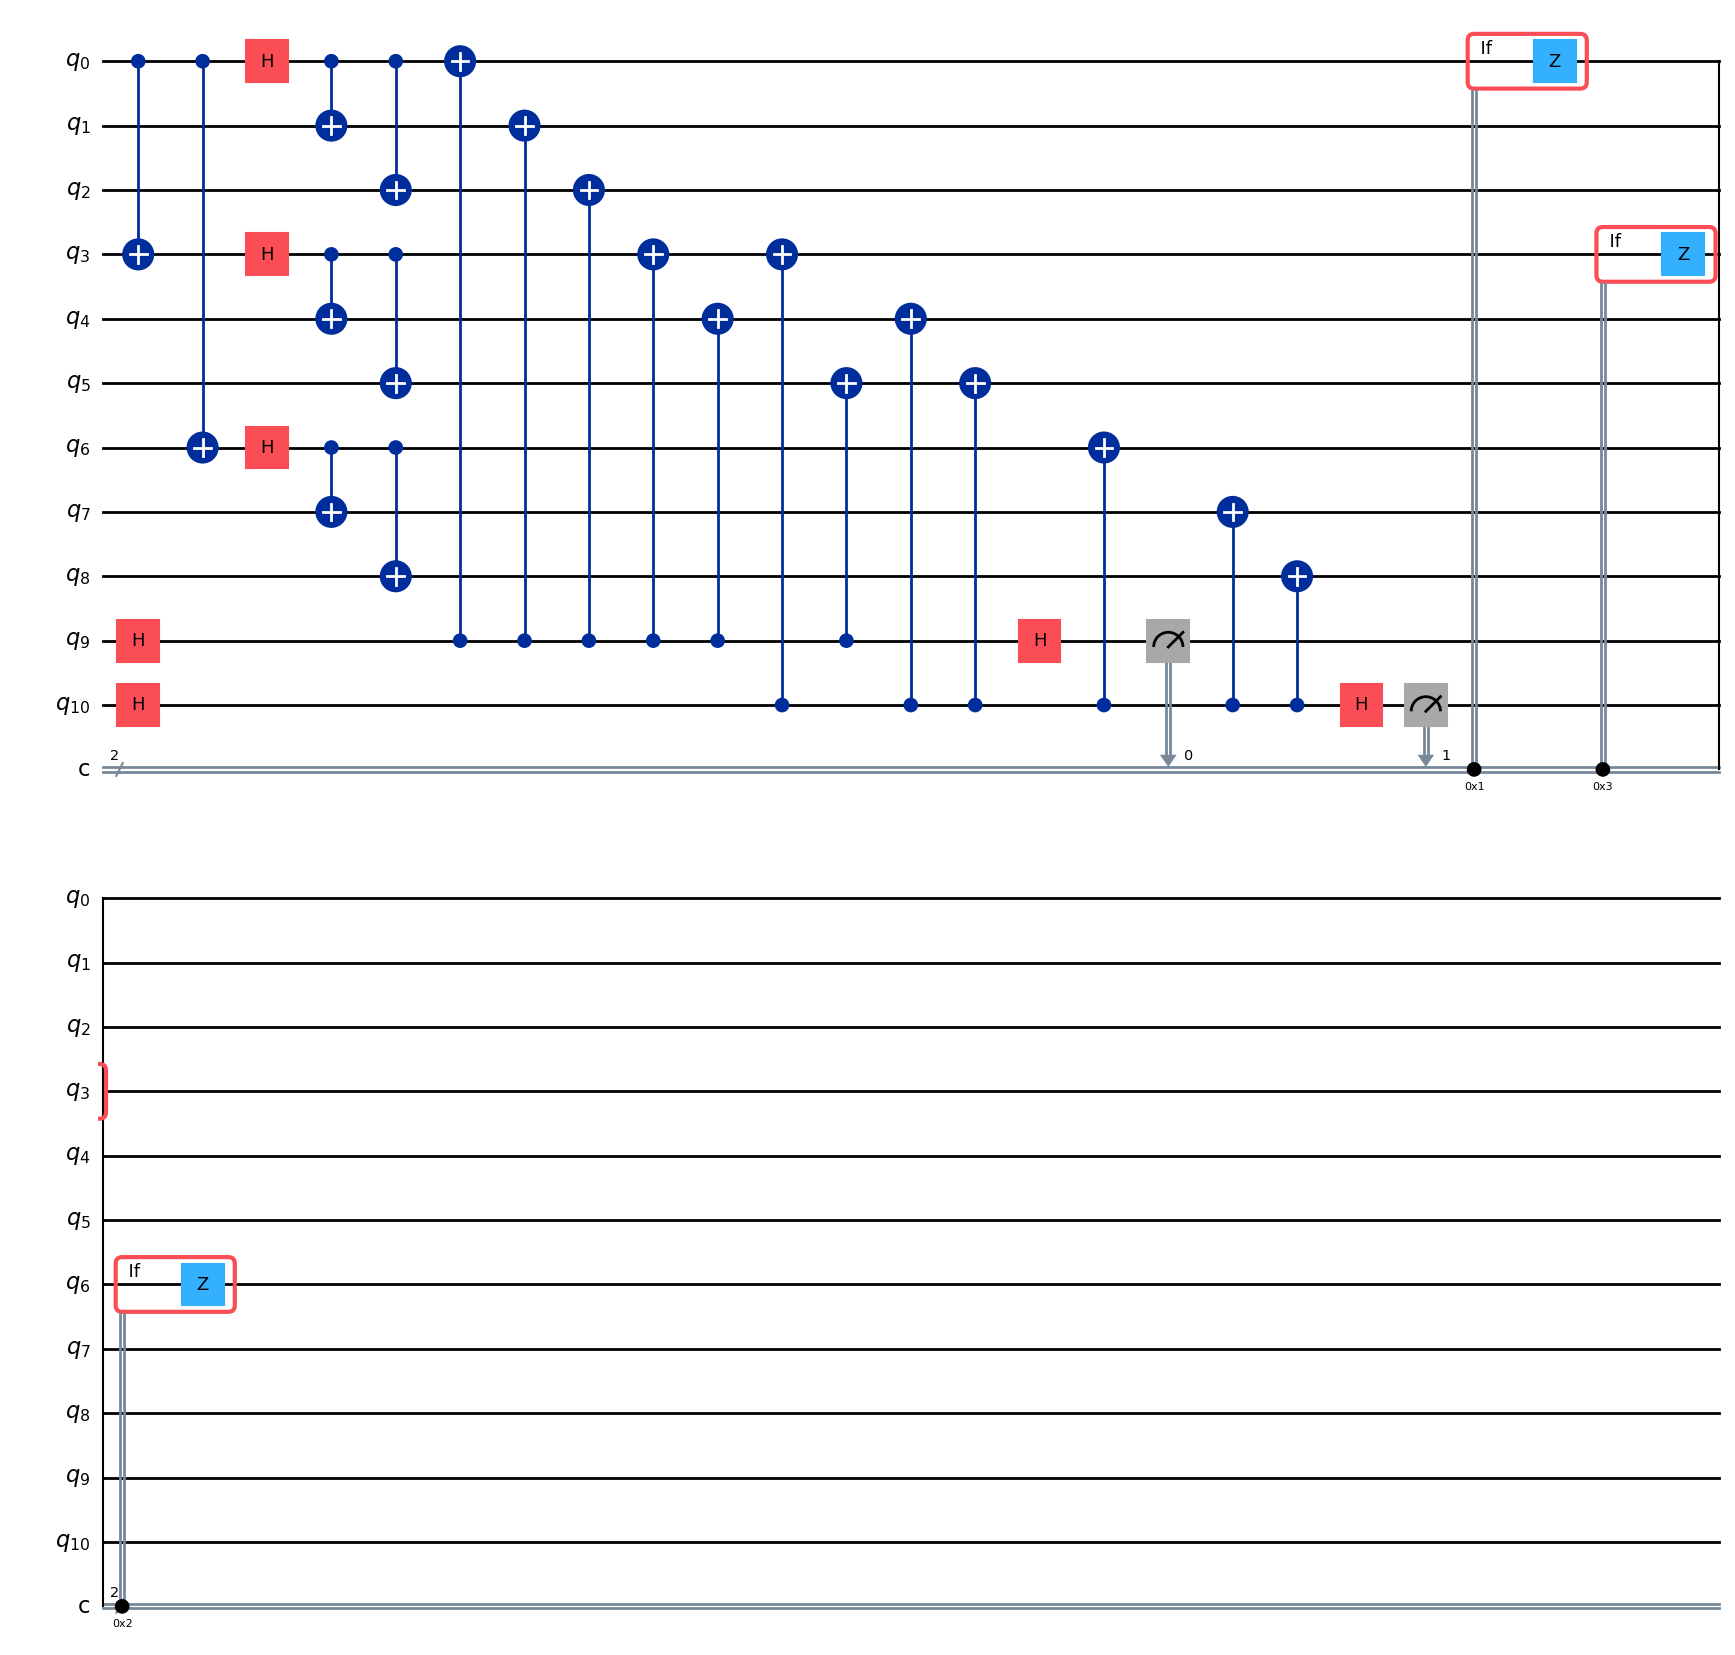

In [41]:
def create_quantum_circuit():
    """
    Creates a quantum circuit with a specific configuration, including error phase,
    syndrome extraction, and conditional Z gates based on measurement outcomes.

    Returns:
        QuantumCircuit: The constructed quantum circuit.
    """
    # Initialize quantum and classical registers
    qreg = QuantumRegister(11, 'q')
    creg = ClassicalRegister(2, 'c')
    
    # Create the quantum circuit with the registers
    qc = QuantumCircuit(qreg, creg)

    # Apply initial gates
    qc.cx(qreg[0], qreg[3])
    qc.cx(qreg[0], qreg[6])
    qc.h(qreg[0])
    qc.h(qreg[3])
    qc.h(qreg[6])

    # Entanglement gates
    qc.cx(qreg[0], qreg[1])
    qc.cx(qreg[3], qreg[4])
    qc.cx(qreg[6], qreg[7])
    qc.cx(qreg[0], qreg[2])
    qc.cx(qreg[3], qreg[5])
    qc.cx(qreg[6], qreg[8])



    # Syndrome extraction
    qc.h(qreg[10])
    qc.h(qreg[9])
    for i in range(6):
        qc.cx(qreg[9], qreg[i])
    for i in range(6):
        qc.cx(qreg[10], qreg[3 + i])
    qc.h(qreg[10])
    qc.h(qreg[9])

    # Measurements
    qc.measure(qreg[9], creg[0])
    qc.measure(qreg[10], creg[1])

    # Apply conditional Z gates based on measurement outcomes
    with qc.if_test((creg, 0b01)):
        qc.z(qreg[0])            # Apply Z on qubit 0 if error on the first block

    with qc.if_test((creg, 0b11)):
        qc.z(qreg[3])                # Apply Z on qubit 0 if error on secound block

    with qc.if_test((creg, 0b10)):
        qc.z(qreg[6])           # Apply Z on qubit 6 if error is on the final block

    return qc

# Create and draw the quantum circuit
quantum_circuit = create_quantum_circuit()
quantum_circuit.draw('mpl')

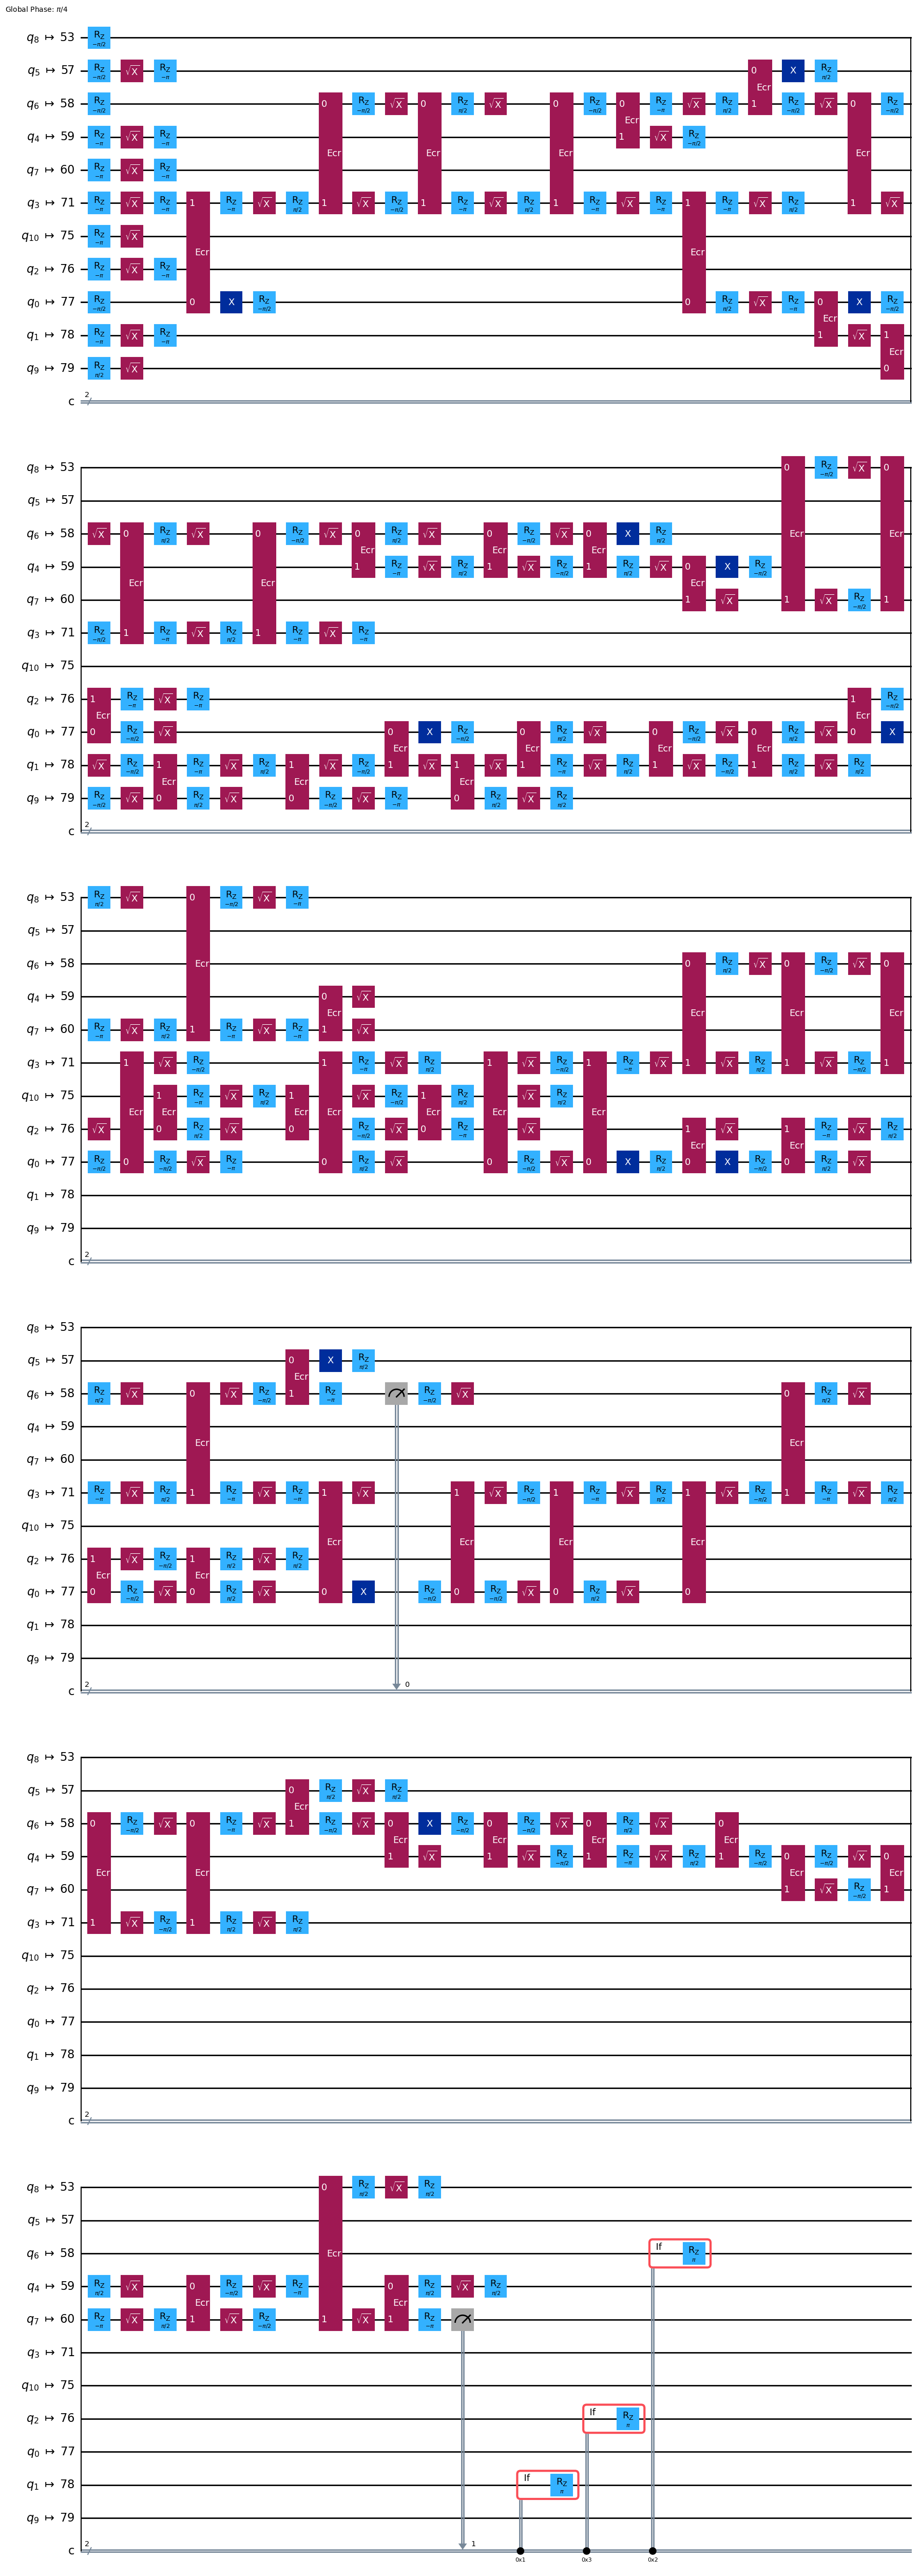

In [42]:
from qiskit import generate_preset_pass_manager


pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(quantum_circuit)
 
isa_circuit.draw("mpl", idle_wires=False)

# run on hardware with z error correction

In [43]:
sampler = Sampler(mode=backend)

job = sampler.run([isa_circuit])
print("Job ID:", job.job_id())
result = job.result()[0]
counts = result.join_data().get_counts()


print("Counts from hardware:", counts)

# # 6. Plot the result
plot_histogram(counts)
plt.show()



Job ID: cxrsz343wrp0008kp0s0
Counts from hardware: {'01': 1221, '00': 911, '11': 1092, '10': 872}
